In [106]:
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from PIL import Image
from typing import List, Sequence
from statistics import median
from typing import Sequence
from more_itertools import chunked
import cv2

In [107]:
# ISCC dct implementation
def alg_dct(v):
    # type: (Sequence[float]) -> List
    """
    Discrete cosine transform.
    See: [nayuki.io](https://www.nayuki.io/page/fast-discrete-cosine-transform-algorithms).
    :param Sequence[float] v: Input vector for DCT calculation.
    :return: DCT Transformed vector.
    :rtype: List
    """
    n = len(v)
    if n == 1:
        return list(v)
    elif n == 0 or n % 2 != 0:
        raise ValueError()
    else:
        half = n // 2
        alpha = [(v[i] + v[-(i + 1)]) for i in range(half)]
        beta = [
            (v[i] - v[-(i + 1)]) / (math.cos((i + 0.5) * math.pi / n) * 2.0) for i in range(half)
        ]
        alpha = alg_dct(alpha)
        beta = alg_dct(beta)
        result = []
        for i in range(half - 1):
            result.append(alpha[i])
            result.append(beta[i] + beta[i + 1])
        result.append(alpha[-1])
        result.append(beta[-1])
        return result

In [108]:
# ISCC content code for images
def soft_hash_image_v0(pixels, bits=64):
    # type: (Sequence[int], int) -> bytes
    """
    Calculate image hash from normalized grayscale pixel sequence of length 1024.

    :param Sequence[int] pixels:
    :param int bits: Bit-length of image hash (default 64).
    :return: Similarity preserving Image-Hash digest.
    :rtype: bytes
    """
    if not bits <= 256:
        raise AssertionError(f"{bits} bits exeeds max lenght 256 for soft_hash_image")

    # DCT per row
    dct_row_lists = []
    for pixel_list in chunked(pixels, 32):
        dct_row_lists.append(alg_dct(pixel_list))

    # DCT per col
    dct_row_lists_t = list(map(list, zip(*dct_row_lists)))
    dct_col_lists_t = []
    for dct_list in dct_row_lists_t:
        dct_col_lists_t.append(alg_dct(dct_list))

    dct_matrix = list(map(list, zip(*dct_col_lists_t)))

    def flatten(m, x, y):
        """Extract and flatten an 8 x 8 slice from a 2d matrix starting at col/row."""
        return [v for sublist in m[y : y + 8] for v in sublist[x : x + 8]]

    bitstring = ""
    slices = ((0, 0), (1, 0), (0, 1), (1, 1))

    for xy in slices:
        # Extract 8 x 8 slice
        flat_list = flatten(dct_matrix, *xy)
        # Calculate median
        med = median(flat_list)
        # Append 64-bit digest by comparing to median
        for value in flat_list:
            if value > med:
                bitstring += "1"
            else:
                bitstring += "0"
        bl = len(bitstring)
        if bl >= bits:
            hash_digest = int(bitstring, 2).to_bytes(bl // 8, "big", signed=False)
            return bitstring

In [109]:
def get_iscc_image_code(img):
    # Replace background color from transparent to white
    white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
    img = Image.alpha_composite(white_bg, img.convert("RGBA"))
    # Convert image to greyscale
    img_greyscale = img.convert('L')
    # Resize the greyscale image to 32x32 pixels
    img_32x32 = img_greyscale.resize((32,32),Image.BICUBIC)
    # Load pixels
    pixels: list[int] = list(img_32x32.getdata())
    return soft_hash_image_v0(pixels)

In [110]:
# Hamming distnace
relevant_bits = 64
def hamming_distance(bitstring1, bitstring2):
    count = 0
    for i in range (relevant_bits):
        if bitstring1[i] != bitstring2[i]:
            count += 1
    return count

In [111]:
# Load original image
original_img = cv2.imread("./images/fox-gpt-image-1.png", 0)
print(original_img.shape)

(1024, 1024)


In [112]:
# Creaet ISCC form original image
original_iscc = get_iscc_image_code(Image.fromarray(original_img))

In [113]:
def interpolation(img, alpha):
    hight, width = img.shape
    # Gaußsches Rauschen erzeugen
    noise = np.random.normal(0, 255, (hight, width)).astype(np.float32)
    # Normalisieren auf [0, 1]
    noise = cv2.normalize(noise, None, 0, 1.0, cv2.NORM_MINMAX)
    # In [0, 255]
    noise = (noise * 255).astype(np.uint8)
    # Mischung aus Original und Rauschen
    noisy_img_vector = cv2.addWeighted(img, 1 - alpha, noise, alpha, 0)
    noisy_img = Image.fromarray(noisy_img_vector)
    noisy_img.save(f"./poisioning/interpolation/interpolation_{alpha}.png")
    return noisy_img

In [114]:
def additive(img, alpha):
    hight, width = img.shape
    # Gaußsches Rauschen erzeugen (Mittelwert = 0, Std = 255*alpha)
    noise = np.random.normal(0, 255 * alpha, (hight, width)).astype(np.float32)
    # Zum Bild addieren
    noisy_img = img.astype(np.float32) + noise
    # Begrenzen auf [0,255]
    noisy_img_vector = np.clip(noisy_img, 0, 255).astype(np.uint8)
    noisy_img = Image.fromarray(noisy_img_vector)
    noisy_img.save(f"./poisioning/additive/additive_{alpha}.png")
    return noisy_img

In [115]:
# alpha = 0 -> Originalbild
# alpha = 1 -> komplett weißes Bild (maximales Rauschen)
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

In [116]:
# create images for interpolation and additive
i_images = []
a_images = []
for alpha in alphas:
    i_images.append(interpolation(original_img, alpha))
    a_images.append(additive(original_img, alpha))

In [117]:
# add labels to image arrays
interpolation_images = []
interpolation_images.append(i_images)
interpolation_images.append("interpolation")
additive_images = []
additive_images.append(a_images)
additive_images.append("additive")

In [118]:
def compare_iscc_images(original_iscc, test_images, alphas):
    data = []
    simularity = []
    for img in test_images[0]:
        iscc = get_iscc_image_code(img)
        distance = hamming_distance(original_iscc, iscc)
        simularity.append(100 - (distance * 100 / relevant_bits))
    #data.append([round(alpha * 100) for alpha in alphas])
    data.append(alphas)
    data.append(simularity)
    data.append(test_images[1]) # add label
    return data

In [119]:
# Data interpolation images
data_interpolation_images = compare_iscc_images(original_iscc, interpolation_images, alphas)
# Data additive images
data_additive_images = compare_iscc_images(original_iscc, additive_images, alphas)

In [120]:
data_interpolation_images[0]

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [121]:
data_additive_images[0]

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [122]:
data_interpolation_images[1]

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 96.875,
 100.0,
 96.875,
 100.0,
 96.875,
 100.0,
 96.875,
 96.875,
 96.875,
 93.75,
 90.625,
 43.75]

In [123]:
data_additive_images[1]

[100.0,
 100.0,
 100.0,
 100.0,
 96.875,
 100.0,
 96.875,
 100.0,
 100.0,
 100.0,
 96.875,
 96.875,
 96.875,
 100.0,
 96.875,
 96.875,
 100.0,
 100.0,
 93.75,
 100.0,
 90.625]

In [124]:
data_interpolation_images[2]

'interpolation'

In [125]:
data_additive_images[2]

'additive'

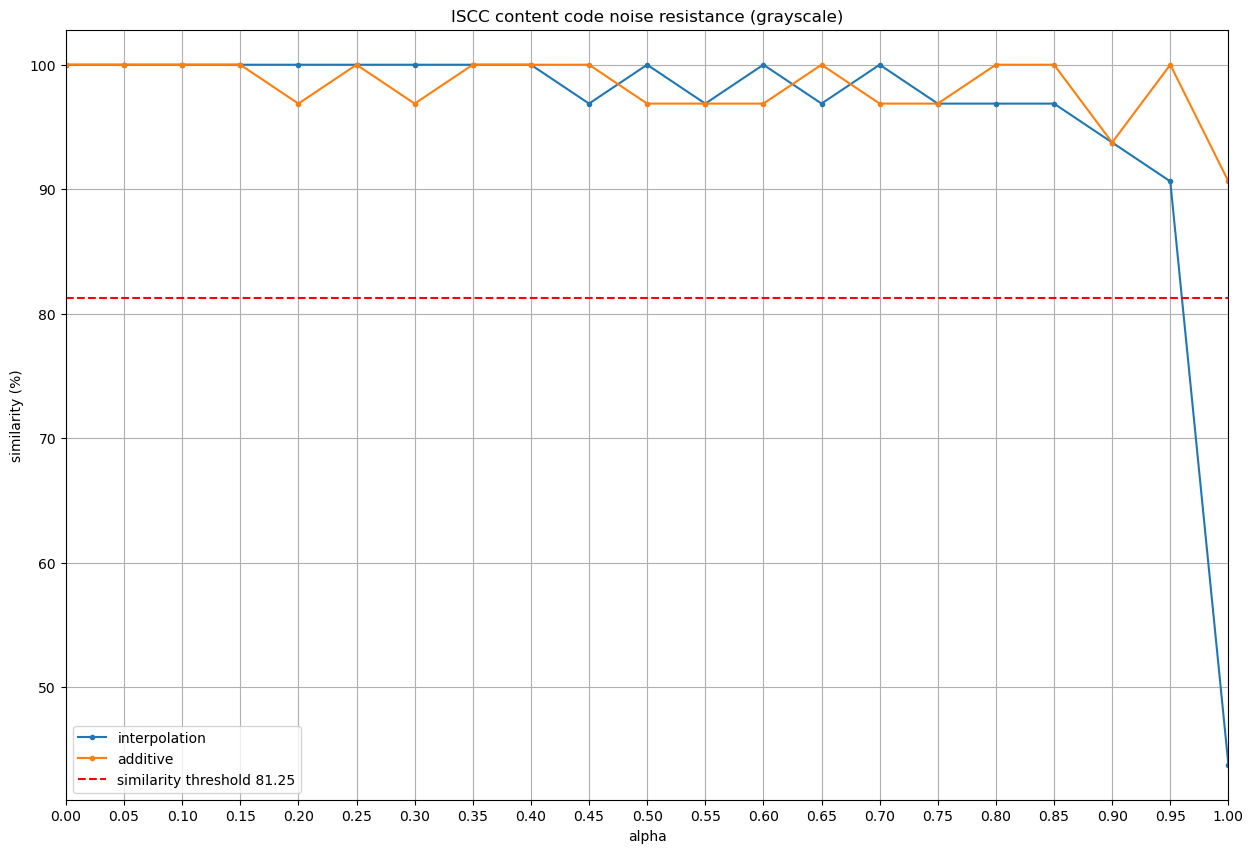

In [126]:
plt.figure(figsize=(15, 10))
plt.plot(data_interpolation_images[0], data_interpolation_images[1], marker=".", label=f"{data_interpolation_images[2]}")
plt.plot(data_additive_images[0], data_additive_images[1], marker=".", label=f"{data_additive_images[2]}")
plt.title("ISCC content code noise resistance (grayscale)")
plt.xlabel("alpha")
plt.ylabel("similarity (%)")
plt.axhline(y=81.25, color='r', linestyle='--', label=f'similarity threshold 81.25')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.05))  # 0.05 Schritte auf der X-Achse
ax.yaxis.set_major_locator(MultipleLocator(10))   # z.B. 0.1 Schritte auf der Y-Achse
ax.set_xlim(0.0, 1.0)
plt.show()